# DS CxC Competition -- Cyclica

## Team Name: M3 biubiubiu

### Author: Xiyao Wang, Xiaonan Liu, Tao Shan, Colby Wang

### Description: 

* We are given a dataset by Cyclica with all verifiable drug binding sites onto AlphaFold2 protein structures and the protein residue is labeled as 'drug binding' or 'non-drug binding'. In this challenge, we are trying to develop a classification model to predict 'drug binding' or 'non-drug binding' for any query residue, and defend the model by demonstrating which features are most important for drug-binding. 

* To perform this task, we will study the data, discover patterns and tendencies, establish and compare different methods to predict the labels.


### Strategies:

*   Data Analytics steps including Data Exploration, Data Preprocessing, Data Modeling and Submission.
*   Each section above includes an summary for the code.

### Hyperlinks: 
*   [Data Exploration and Pre-processing](#1)
*   [Data Modeling](#2)
*   [LightGBM](#3)
*   [Submission](#4)

# Import Dataset

Note: this notebook is supposed to be executed in Google Colab.

Import the two provided file in format .csv.gz using the code below or upload them by hand using the folder on the left hand side menu.

In [1]:
from google.colab import files
uploaded = files.upload()
%ls

Saving af2_dataset_testset_unlabeled.csv.gz to af2_dataset_testset_unlabeled.csv.gz
Saving af2_dataset_training_labeled.csv.gz to af2_dataset_training_labeled.csv.gz
af2_dataset_testset_unlabeled.csv.gz  sample_data/
af2_dataset_training_labeled.csv.gz


Read the data set from the files and take a quick glance.

In [2]:
import pandas as pd
df_test = pd.read_csv("af2_dataset_testset_unlabeled.csv.gz", index_col=0)
df_train = pd.read_csv("af2_dataset_training_labeled.csv.gz", index_col=0)
df_train.head()

,annotation_sequence,feat_A,feat_C,feat_D,feat_E,feat_F,feat_G,feat_H,feat_I,feat_K,...,feat_DSSP_10,feat_DSSP_11,feat_DSSP_12,feat_DSSP_13,coord_X,coord_Y,coord_Z,entry,entry_index,y_Ligand
0,M,False,False,False,False,False,False,False,False,False,...,0,0.0,47,-0.0,-26.499001,-4.742,-35.189999,GEMI5_HUMAN,0,False
1,G,False,False,False,False,False,True,False,False,False,...,0,0.0,0,0.0,-25.158001,-1.342,-34.104000,GEMI5_HUMAN,1,False
2,Q,False,False,False,False,False,False,False,False,False,...,1,-0.0,-1,-0.0,-21.926001,-1.641,-32.175999,GEMI5_HUMAN,2,False
3,E,False,False,False,True,False,False,False,False,False,...,706,-0.1,705,-0.0,-22.073999,0.654,-29.171000,GEMI5_HUMAN,3,False
4,P,False,False,False,False,False,False,False,False,False,...,0,0.0,705,-0.2,-19.783001,2.670,-26.858999,GEMI5_HUMAN,4,False


<a name="1"></a>
# Data Exploration and Pre-processing

### Description:

* Checked missing values: there are no missing values except column `annotation_atomrec`, which we will later process using one-hot encoding to impute.
* Examined the response variable to predict on, and find that it is highly imbalanced. We tried to use downsampling to deal with it and will compare the performance of the models with using the entire dataset.
* Attempted to find important variables using correlation map and density plot. We didn't find any variables that are highly correlated, so we will try to use all the variables to predict the class.


In [3]:
# Import packages
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pickle
import time
import re
import random
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

# preprocessing packages
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, MinMaxScaler
#from category_encoders import WOEEncoder
#from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeClassifier
import lightgbm as ltb
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile
from sklearn.preprocessing import Normalizer
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance, XGBClassifier



In [7]:
# Check all the columns
df_train.columns

Index(['annotation_sequence', 'feat_A', 'feat_C', 'feat_D', 'feat_E', 'feat_F',
       'feat_G', 'feat_H', 'feat_I', 'feat_K', 'feat_L', 'feat_M', 'feat_N',
       'feat_P', 'feat_Q', 'feat_R', 'feat_S', 'feat_T', 'feat_V', 'feat_W',
       'feat_Y', 'annotation_atomrec', 'feat_PHI', 'feat_PSI', 'feat_TAU',
       'feat_THETA', 'feat_BBSASA', 'feat_SCSASA', 'feat_pLDDT', 'feat_DSSP_H',
       'feat_DSSP_B', 'feat_DSSP_E', 'feat_DSSP_G', 'feat_DSSP_I',
       'feat_DSSP_T', 'feat_DSSP_S', 'feat_DSSP_6', 'feat_DSSP_7',
       'feat_DSSP_8', 'feat_DSSP_9', 'feat_DSSP_10', 'feat_DSSP_11',
       'feat_DSSP_12', 'feat_DSSP_13', 'coord_X', 'coord_Y', 'coord_Z',
       'entry', 'entry_index', 'y_Ligand'],
      dtype='object')

In [ ]:
# check missing values
df_train.isna().sum()

In [4]:
# Further example entry_index column
max(df_train['entry_index'].unique())

7384

In [ ]:
# Overall summary of the dataset
df_train.describe()

,feat_PHI,feat_PSI,feat_TAU,feat_THETA,feat_BBSASA,feat_SCSASA,feat_pLDDT,feat_DSSP_6,feat_DSSP_7,feat_DSSP_8,feat_DSSP_9,feat_DSSP_10,feat_DSSP_11,feat_DSSP_12,feat_DSSP_13,coord_X,coord_Y,coord_Z,entry_index
count,497166.000000,497166.000000,497166.000000,497166.000000,497166.000000,4.971660e+05,497166.000000,497166.000000,497166.000000,497166.000000,497166.000000,497166.000000,497166.000000,497166.000000,497166.000000,497166.000000,497166.000000,497166.000000,497166.000000
mean,-1.162007,0.780075,-0.108342,1.854782,16.746550,5.209644e+01,75.733749,-1.789849,-1.160675,1.754382,-1.140480,-0.053135,-0.177757,0.128386,-0.201625,-3.927826,1.956133,-1.099622,535.495128
std,1.039634,1.520499,1.833996,0.469940,18.494097,4.792873e+01,26.971019,58.176800,1.058466,60.429611,1.062049,57.906105,0.156652,61.219479,0.232904,25.770530,20.641283,26.637590,665.740408
min,-3.141557,-3.141564,-3.141578,0.000000,0.000000,-2.842171e-14,0.000000,-2281.000000,-4.000000,-2281.000000,-4.000000,-2280.000000,-1.800000,-2281.000000,-2.900000,-149.393997,-114.931000,-152.839005,0.000000
25%,-1.686451,-0.654101,-2.067246,1.590771,1.239801,5.274057e+00,55.360000,-4.000000,-2.200000,-1.000000,-2.200000,-2.000000,-0.200000,-2.000000,-0.200000,-18.850000,-9.518750,-16.964001,172.000000
50%,-1.199133,0.241335,0.775206,1.756220,8.788650,4.352778e+01,89.530000,-2.000000,-0.700000,2.000000,-0.600000,1.000000,-0.200000,-1.000000,-0.200000,-2.881000,1.206000,-0.681000,365.000000
75%,-1.047934,2.297116,0.966645,2.122055,29.958422,8.623462e+01,95.960000,0.000000,-0.200000,4.000000,-0.200000,2.000000,-0.100000,2.000000,-0.100000,11.469000,13.148000,14.147000,667.000000
max,3.141575,3.141584,3.141568,3.137176,99.338342,2.200520e+02,98.980000,2281.000000,0.000000,2281.000000,-0.000000,2281.000000,0.000000,2282.000000,-0.000000,162.250000,103.135002,176.059998,7384.000000


## Distribution of the Response Variable

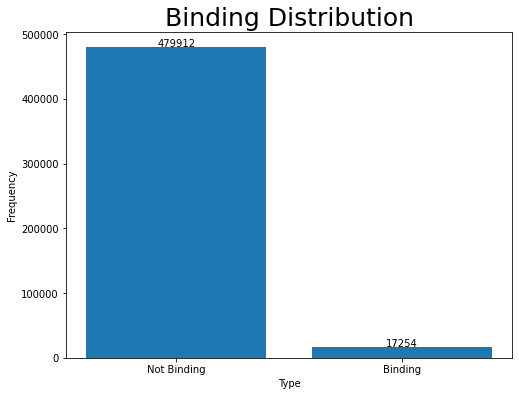

In [5]:
# Distribution for the two classes of the variable to predict
# The dataset is highly imbalanced
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]+1000, y[i], ha = 'center')

x=["Not Binding", "Binding"]

Binding = sum(df_train["y_Ligand"] == True)
y=[df_train.shape[0]-Binding, Binding]

plt.figure(figsize = (8,6))
plt.bar(x,y)
addlabels(x,y)
plt.xlabel('Type')
plt.ylabel('Frequency')
plt.title('Binding Distribution', fontsize = 25)
plt.savefig('Fraud_Label_Distribution.jpg')
plt.show()

## Correlation Map

In [6]:
# Prepare the dataset for correlation map to explore any important variable
without_categorical_columns = [col for col in df_train.columns if df_train[col].dtype != "O"]
without_categorical_columns = without_categorical_columns[0:42]

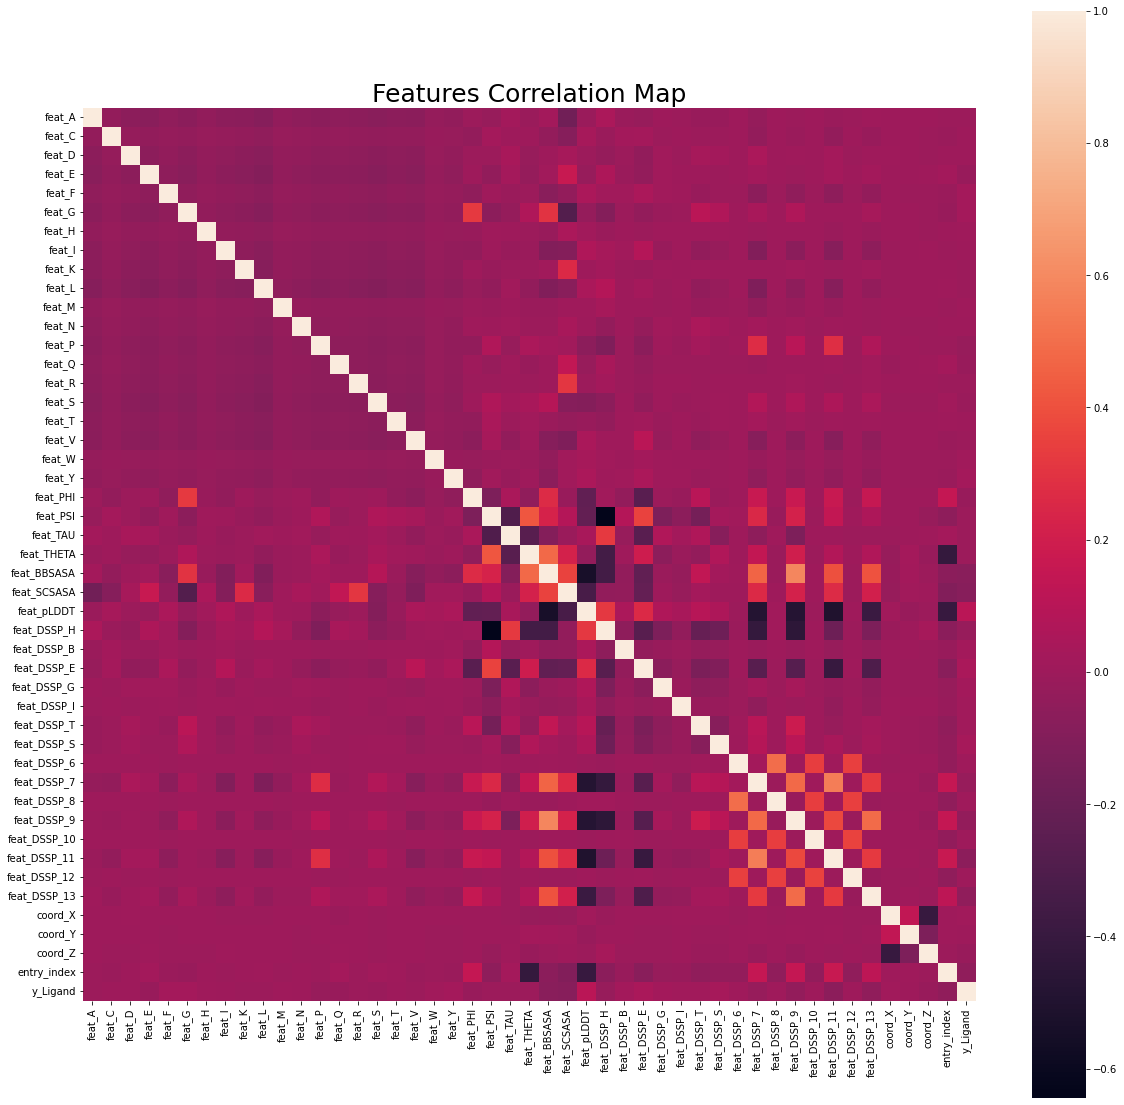

In [7]:
# Draw correlation map
corr = df_train.corr()
plt.figure(figsize = (20,20))
sns.heatmap(corr, square=True)
plt.title('Features Correlation Map', fontsize = 25)
plt.savefig('feature_corr.jpg')
plt.show()

From the map, we can see that there are no specific variable that is highly correlated. Thus, we will try to compare the performance of different models using all the variables with using non-categorical variables (the variable `entry` is dropped).

## Downsampling

Since the data is highly imbalanced, we will try to subsampling from the dataset and try to build models from a more balanced data.

In [8]:
# Randomly select the same number of data that is flaged as non binding as binding
random.seed(12345)
Binding = sum(df_train["y_Ligand"] == True)
binding_data = df_train[df_train["y_Ligand"] == True]
non_binding_data = df_train[df_train["y_Ligand"] == False].sample(n= 1 * Binding)
downsample = pd.concat([binding_data, non_binding_data])
downsample.head()
# extract the label and feature
x_down = downsample.drop(["y_Ligand"], axis=1)
y_down = downsample["y_Ligand"]

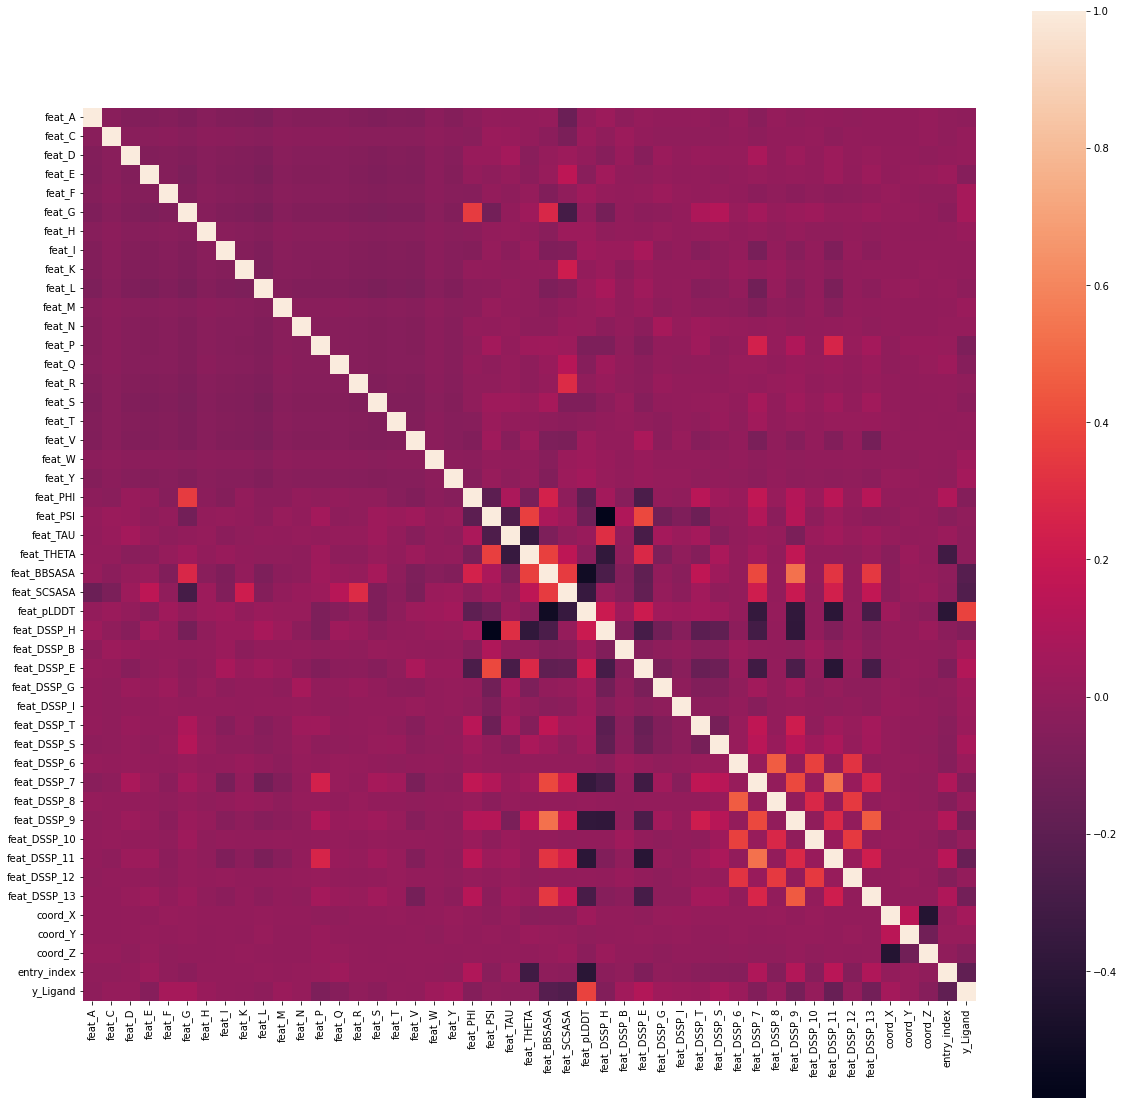

In [9]:
# Compare the correlation map after downsampling
corr = downsample[downsample.columns].corr()
plt.figure(figsize = (20,20))
sns.heatmap(corr, square=True)
plt.show()

## Draw the density plot

In [10]:
df_train.columns.get_loc("feat_pLDDT")

28

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


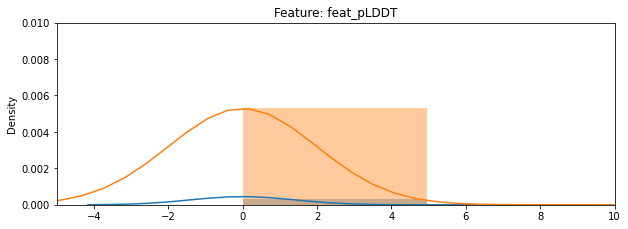

In [11]:
# draw the density plots
plt.figure(figsize=(10,30*4))
import matplotlib.gridspec as gridspec
features = df_train.iloc[:,28:29].columns
gs = gridspec.GridSpec(30, 1)
for i, feature in enumerate(df_train[features]):
    ax = plt.subplot(gs[i])
    plt.xlim(-5,10)
    plt.ylim(0,0.01)
    sns.distplot(df_train[feature][df_train["y_Ligand"] == True], bins=20)
    sns.distplot(df_train[feature][df_train["y_Ligand"] == False], bins=20)
    ax.set_xlabel('')
    ax.set_title('Feature: ' + str(feature))
plt.show()

After downsampling, the variables are still not important/highly correlated after looking at the density plot for the variable that has the highest correlation with the response variable. Therefore, we will try to model the data using all of them instead of picking important ones.

## Prepare the Dataset for Downsampling

In [12]:
# extract the label and feature
x_down = downsample.drop(["y_Ligand"], axis=1)
y_down = downsample["y_Ligand"]

In [13]:
# train test split for downsample
train_x_down,test_x_down,train_y_down,test_y_down = train_test_split(x_down,y_down,test_size=0.2, random_state=123)

In [14]:
downsample.columns

Index(['annotation_sequence', 'feat_A', 'feat_C', 'feat_D', 'feat_E', 'feat_F',
       'feat_G', 'feat_H', 'feat_I', 'feat_K', 'feat_L', 'feat_M', 'feat_N',
       'feat_P', 'feat_Q', 'feat_R', 'feat_S', 'feat_T', 'feat_V', 'feat_W',
       'feat_Y', 'annotation_atomrec', 'feat_PHI', 'feat_PSI', 'feat_TAU',
       'feat_THETA', 'feat_BBSASA', 'feat_SCSASA', 'feat_pLDDT', 'feat_DSSP_H',
       'feat_DSSP_B', 'feat_DSSP_E', 'feat_DSSP_G', 'feat_DSSP_I',
       'feat_DSSP_T', 'feat_DSSP_S', 'feat_DSSP_6', 'feat_DSSP_7',
       'feat_DSSP_8', 'feat_DSSP_9', 'feat_DSSP_10', 'feat_DSSP_11',
       'feat_DSSP_12', 'feat_DSSP_13', 'coord_X', 'coord_Y', 'coord_Z',
       'entry', 'entry_index', 'y_Ligand'],
      dtype='object')

<a name="2"></a>
# Data Modeling

### Description

* Dataset Split and training: The train set is further split into train and test sets with 80% training and 20% testing.

* Models: Logistic Regression, KNN, Decision Tree, SVM, Nerual Network, XGBoost, LightGBM, Random Forest.
* Compare Methods: Using `eval_model` function with ROC_AUC and PR_AUC, which is provided by Cyclica.
* Parameter Pruning for LightGBM, and choose LightGBM since it has better solutions and is further trained with cross validation.
* The best model is Random Forest.
* The best score: **ROC_AUC = 0.876; PR_AUC = 0.372**.


Function of evaluation

In [35]:
from sklearn import metrics
def eval_model():
  fpr, tpr, thresholds = metrics.roc_curve(y_test_df, y_test_pred, pos_label=1)
  auc_roc = metrics.auc(fpr, tpr)

  precision, recall, _ = metrics.precision_recall_curve(y_test_df, y_test_pred)
  auc_pr = metrics.auc(recall, precision)

  print(f"ROC-AUC: {auc_roc} \n PR-AUC {auc_pr}")
# eval_model()

## Dataset Spliting

Entire dataset

In [36]:
from sklearn.model_selection import train_test_split
# Entire dataset
train_df, test_df = train_test_split(df_train, test_size=0.2, random_state=42)

In [37]:
# Randomly select the same number of data that is flaged as non binding as binding
random.seed(12345)
Binding = sum(train_df["y_Ligand"] == True)
binding_data = train_df[train_df["y_Ligand"] == True]
non_binding_data = train_df[train_df["y_Ligand"] == False].sample(n= 1 * Binding)
downsample = pd.concat([binding_data, non_binding_data])
downsample.head()
# extract the label and feature
x_down = downsample.drop(["y_Ligand"], axis=1)
y_down = downsample["y_Ligand"]

In [38]:
x_test_df = test_df.drop(["y_Ligand"], axis=1)
y_test_df = test_df["y_Ligand"]

Without categorical columns

In [39]:
# Dataset: without categorical columns
without_categorical_columns = [col for col in x_down.columns if x_down[col].dtype != "O"]
without_categorical_columns = without_categorical_columns[0:47]
without_categorical_columns

['feat_A',
 'feat_C',
 'feat_D',
 'feat_E',
 'feat_F',
 'feat_G',
 'feat_H',
 'feat_I',
 'feat_K',
 'feat_L',
 'feat_M',
 'feat_N',
 'feat_P',
 'feat_Q',
 'feat_R',
 'feat_S',
 'feat_T',
 'feat_V',
 'feat_W',
 'feat_Y',
 'feat_PHI',
 'feat_PSI',
 'feat_TAU',
 'feat_THETA',
 'feat_BBSASA',
 'feat_SCSASA',
 'feat_pLDDT',
 'feat_DSSP_H',
 'feat_DSSP_B',
 'feat_DSSP_E',
 'feat_DSSP_G',
 'feat_DSSP_I',
 'feat_DSSP_T',
 'feat_DSSP_S',
 'feat_DSSP_6',
 'feat_DSSP_7',
 'feat_DSSP_8',
 'feat_DSSP_9',
 'feat_DSSP_10',
 'feat_DSSP_11',
 'feat_DSSP_12',
 'feat_DSSP_13',
 'coord_X',
 'coord_Y',
 'coord_Z',
 'entry_index']

## Logistic Regression

Without categorical variables

In [21]:
logreg =  LogisticRegression(solver='liblinear')
logreg.fit(x_down[without_categorical_columns],y_down)
y_test_pred=logreg.predict_proba(x_test_df[without_categorical_columns])[:,1]
eval_model()

ROC-AUC: 0.7535984664099515 
 PR-AUC 0.08465174411955534


## Decision Tree

In [22]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Define your decision tree model
decisionTree = DecisionTreeClassifier(max_depth=5)

# Fit the model to the training data
decisionTree.fit(x_down[without_categorical_columns], y_down)

# Use the trained model to make predictions on the test data
y_test_pred = decisionTree.predict_proba(x_test_df[without_categorical_columns])[:,1]
eval_model()

ROC-AUC: 0.7412188640681124 
 PR-AUC 0.05766436661696809


## SVM

Due to the slowness and bad performance, we did not rerun the code and just keep the performance results for SVM when using all the categorical variables.

In [ ]:
# # SVM
# from sklearn import datasets
# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score

# # train SVM model
# svm = SVC(kernel='rbf',probability=True)
# svm.fit(x_down[without_categorical_columns],y_down)

# # make predictions on test set
# y_test_pred=svm.predict_proba(x_test_df[without_categorical_columns])[:,1]

# # eval_model()

## XGBoost

In [23]:
import xgboost 
xgb = xgboost.XGBClassifier()
# xgb = xgboost.XGBClassifier(tree_method='gpu_hist')
xgb.fit(x_down[without_categorical_columns], y_down)
y_test_pred = xgb.predict_proba(x_test_df[without_categorical_columns])[:,1]
eval_model()

ROC-AUC: 0.844750225979209 
 PR-AUC 0.2056400492004147


## LightGBM

In [24]:
# build the lightgbm model
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(x_down[without_categorical_columns], y_down)
y_test_pred = clf.predict_proba(x_test_df[without_categorical_columns])[:,1]
eval_model()

ROC-AUC: 0.8685832982507833 
 PR-AUC 0.2793862012130758


## Random Forest

In [25]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=150)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(x_down[without_categorical_columns], y_down)

# y_test_pred=clf.predict(X_test[without_categorical_columns])
# predict_proba(X_test)[:,1]
y_test_pred=clf.predict_proba(x_test_df[without_categorical_columns])[:,1]
eval_model()

ROC-AUC: 0.8715173624221333 
 PR-AUC 0.35106337023170275


In [26]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=150,bootstrap=False,max_features = "log2",min_samples_split=3)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(x_down[without_categorical_columns], y_down)

y_test_pred=clf.predict_proba(x_test_df[without_categorical_columns])[:,1]
eval_model()

ROC-AUC: 0.8761726561612551 
 PR-AUC 0.3665412627496237


In [27]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100,bootstrap=False,max_features = "log2",min_samples_split=3)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(x_down[without_categorical_columns], y_down)

y_test_pred=clf.predict_proba(x_test_df[without_categorical_columns])[:,1]
eval_model()

ROC-AUC: 0.8738303379053605 
 PR-AUC 0.36301928717229653


In [28]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100,bootstrap=False,max_features = "log2",min_samples_split=5)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(x_down[without_categorical_columns], y_down)

y_test_pred=clf.predict_proba(x_test_df[without_categorical_columns])[:,1]
eval_model()

ROC-AUC: 0.8746069172265953 
 PR-AUC 0.364661921042344


In [29]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=150,bootstrap=False,max_features = "log2",min_samples_split=5)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(x_down[without_categorical_columns], y_down)

y_test_pred=clf.predict_proba(x_test_df[without_categorical_columns])[:,1]
eval_model()

ROC-AUC: 0.8764371351117372 
 PR-AUC 0.37127103161632563


<a name="4"></a>
# Submission

* Finally choose Random Forest method to predict the test dataset.

* Useing downsampling and without category columns.

In [41]:
df_train = pd.read_csv("af2_dataset_training_labeled.csv.gz", index_col=0)
df_test = pd.read_csv("af2_dataset_testset_unlabeled.csv.gz", index_col=0)
df_test

,annotation_sequence,feat_A,feat_C,feat_D,feat_E,feat_F,feat_G,feat_H,feat_I,feat_K,...,feat_DSSP_9,feat_DSSP_10,feat_DSSP_11,feat_DSSP_12,feat_DSSP_13,coord_X,coord_Y,coord_Z,entry,entry_index
0,M,False,False,False,False,False,False,False,False,False,...,0.0,0,0.0,0,0.0,33.116001,37.023998,38.417000,QCR1_HUMAN,0
1,A,True,False,False,False,False,False,False,False,False,...,-0.0,2,-0.0,0,0.0,35.849998,34.841000,40.185001,QCR1_HUMAN,1
2,A,True,False,False,False,False,False,False,False,False,...,-0.1,0,0.0,2,-0.0,37.087002,31.719999,40.547001,QCR1_HUMAN,2
3,S,False,False,False,False,False,False,False,False,False,...,-0.1,0,0.0,-2,-0.0,38.095001,28.951000,42.321999,QCR1_HUMAN,3
4,V,False,False,False,False,False,False,False,False,False,...,0.0,0,0.0,0,0.0,41.435001,27.417000,43.703999,QCR1_HUMAN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,L,False,False,False,False,False,False,False,False,False,...,-0.5,-3,-0.3,-3,-0.0,47.813999,7.569000,-27.368999,PDE7A_HUMAN,474
475,P,False,False,False,False,False,False,False,False,False,...,-0.1,0,0.0,-3,-0.0,50.228001,8.068000,-30.333000,PDE7A_HUMAN,475
476,Q,False,False,False,False,False,False,False,False,False,...,-0.0,0,0.0,0,0.0,51.507999,4.896000,-31.959999,PDE7A_HUMAN,476
477,E,False,False,False,True,False,False,False,False,False,...,0.0,0,0.0,0,0.0,54.845001,6.372000,-33.125000,PDE7A_HUMAN,477


In [42]:
# extract the label and feature
Binding = sum(df_train["y_Ligand"] == True)
# Randomly select the same number of data that is flaged as non binding as binding
random.seed(12345)
binding_data = df_train[df_train["y_Ligand"] == True]
non_binding_data = df_train[df_train["y_Ligand"] == False].sample(n= 1 * Binding)
downsample = pd.concat([binding_data, non_binding_data])
downsample.head()
# extract the label and feature
x_down = downsample.drop(["y_Ligand"], axis=1)
y_down = downsample["y_Ligand"]

In [43]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=150,bootstrap=False,max_features = "log2",min_samples_split=5)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(x_down[without_categorical_columns], y_down)

RandomForestClassifier(bootstrap=False, max_features='log2',
                       min_samples_split=5, n_estimators=150)

In [44]:
y_test_submission = clf.predict(df_test[without_categorical_columns])

In [45]:
s = pd.Series(y_test_submission).astype(bool)
s.name = "Predicted"
s.to_csv("submission.csv")